In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import time
import datetime as dt
import random
import psutil
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle
import glob
import pickle
import torchvision
from torch.optim import lr_scheduler
import torch.nn.functional as F
import math
import time

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

def no_of_params(model):
    sum_ = 0.
    for key, value in model.state_dict().items():
        sum_ += torch.prod(torch.tensor(value.shape))
        #print(value, "----------", torch.prod(torch.tensor(value.shape)))
    return int(sum_)

In [111]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        list_IDs,
    ):
        self.list_IDs  = list_IDs
        self.cache     = {}
        self.input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/images/"
        self.label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/labels/"
        
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        if ID in self.cache:
            X = self.cache[ID]['X']
            Y = self.cache[ID]['Y']
        else:
            X = torchvision.io.read_image(
                self.input_dir + str(ID) + ".png "
            ).to(torch.float32)
            X = X[1].unsqueeze(0)/256.
            
            with open(self.label_dir + str(ID), 'rb') as fb:
                Y  = pickle.load(fb)
                
            #Y = [ (i + 3.)/6. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            #Y = [ i/3. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            
            Y = Y[1][0]/3.1415926
            Y = Y - 0.5
            
            Y = torch.tensor( Y, dtype=torch.float32 ).unsqueeze(0)
            
            if psutil.virtual_memory().percent < 50:
                data = {
                    'X' : X,
                    'Y' : Y
                }
                self.cache[ID] = data
        return X,Y
    
all_ids = [str(i) for i in  list(np.arange(0,10000,1))]
train_ids = all_ids[:8000]
val_ids   = all_ids[8000:]#1000]

params = {
    'batch_size'  : 2,
    'shuffle'     : True,
    #'num_workers' : 2
}
training_set         = Dataset(train_ids)
training_generator   = torch.utils.data.DataLoader(
                            training_set,
                            **params,
                            pin_memory=True
                        )
validation_set       = Dataset(val_ids)
validation_generator = torch.utils.data.DataLoader(
                            validation_set,
                            **params,
                            pin_memory=True
                        )

tensor([-0.0449])

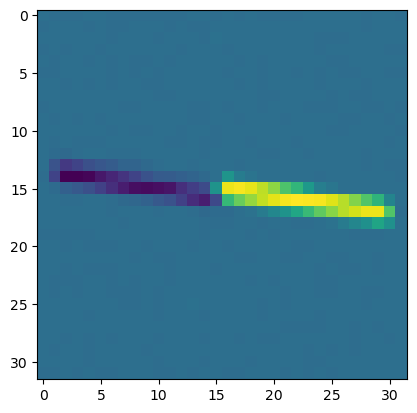

In [41]:
for batch in training_generator:
    break
batch[1].shape
plt.imshow(batch[0][7][0])
batch[1][7]

In [112]:
def train_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    #loss_fn = nn.MSELoss()
    loss_fn = nn.L1Loss()
    
    model.train(True)
    
    for i,batch in enumerate(training_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

def validate_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    #loss_fn = nn.MSELoss()
    loss_fn = nn.L1Loss()
    model.train(False)
    model.eval()
    
    for i,batch in enumerate(validation_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        #optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

In [68]:
# class Network(nn.Module):
#     def __init__(self):
#         super(Network, self).__init__()
#         self.conv1  = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=1)
#         self.bn1    = nn.BatchNorm2d(8)
#         self.conv2  = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=1)
#         self.bn2    = nn.BatchNorm2d(32)
#         self.pool   = nn.MaxPool2d(2,2)
#         self.conv4  = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1)
#         self.bn4    = nn.BatchNorm2d(64)
#         self.conv5  = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=1)
#         self.bn5    = nn.BatchNorm2d(128)
#         self.fc1    = nn.Linear(128*10*10, 1)

#     def forward(self, input):
#         output = torch.tanh(self.bn1(self.conv1(input)))      
#         output = torch.tanh(self.bn2(self.conv2(output)))     
#         output = self.pool(output)                        
#         output = torch.tanh(self.bn4(self.conv4(output)))     
#         output = torch.tanh(self.bn5(self.conv5(output))) 
#         #print(output.shape)
#         output = output.view(-1, 128*10*10)
#         output = self.fc1(output)
#         output = torch.tanh(output)

#         return output


class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1  = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=1)
        self.bn1    = nn.BatchNorm2d(8)
        self.conv2  = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=1)
        self.bn2    = nn.BatchNorm2d(16)
        self.pool   = nn.MaxPool2d(2,2)
        self.conv4  = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=1)
        self.bn4    = nn.BatchNorm2d(32)
        self.conv5  = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.bn5    = nn.BatchNorm2d(64)
        self.fc1    = nn.Linear(64*10*10, 1)

    def forward(self, input):
        output = torch.tanh(self.bn1(self.conv1(input)))      
        output = torch.tanh(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = torch.tanh(self.bn4(self.conv4(output)))     
        output = torch.tanh(self.bn5(self.conv5(output))) 
        #print(output.shape)
        output = output.view(-1, 64*10*10)
        output = self.fc1(output)
        output = torch.tanh(output)

        return output

In [80]:
model = Network()
no_of_params(model)
#model(torch.randn(32,1,32,32))

74405

EPOCH:  1  Train loss:  0.2767  Val loss:  0.1202  LR:  6e-07
EPOCH:  2  Train loss:  0.2688  Val loss:  0.1262  LR:  3.6e-07
EPOCH:  3  Train loss:  0.2703  Val loss:  0.1386  LR:  2.16e-07
EPOCH:  4  Train loss:  0.2773  Val loss:  0.1602  LR:  1.296e-07
EPOCH:  5  Train loss:  0.2927  Val loss:  0.1927  LR:  7.78e-08
EPOCH:  6  Train loss:  0.2819  Val loss:  0.2353  LR:  4.67e-08
EPOCH:  7  Train loss:  0.2703  Val loss:  0.2775  LR:  2.8e-08
EPOCH:  8  Train loss:  0.2732  Val loss:  0.3021  LR:  1.68e-08
EPOCH:  9  Train loss:  0.2933  Val loss:  0.299  LR:  1.01e-08
EPOCH:  10  Train loss:  0.2535  Val loss:  0.2775  LR:  6e-09


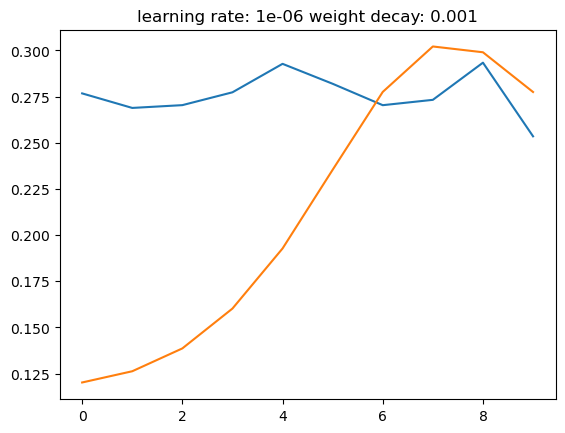

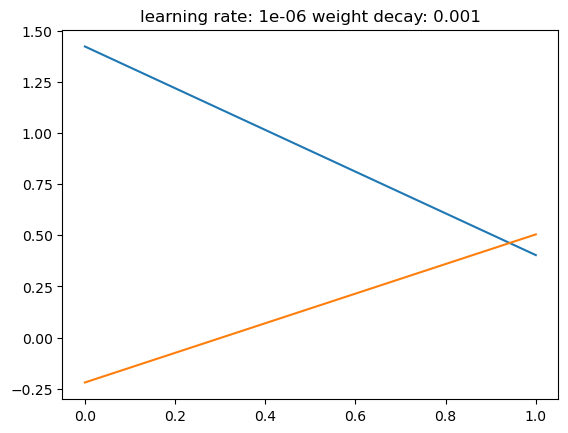

In [105]:
lr = 1e-6
wd = 1e-3
model = Network()

epochs = 400
optimizer = torch.optim.Adam(
        model.parameters(),
        lr           = lr,
        weight_decay = wd
    )

gamma = 0.6#0.85
scheduler_step_size = 1
scheduler = lr_scheduler.StepLR(
    optimizer,
    step_size = scheduler_step_size, 
    gamma     = gamma)

train_losses = []
val_losses   = []
lrs          = []
for epoch in range(epochs):
    train_loss = train_one_epoch(model,optimizer)
    val_loss   = validate_one_epoch(model,optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    lrs.append(scheduler.optimizer.param_groups[0]['lr'])
    scheduler.step()
    print("EPOCH: ",epoch + 1, " Train loss: ", round(train_loss,4), " Val loss: ",round(val_loss,4), " LR: ",round(scheduler.optimizer.param_groups[0]['lr'],10))

txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
plt.title(txt)
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

for batch in validation_generator:
    break
output = model(batch[0])
output
plt.title(txt)
plt.plot(output.detach().numpy()*3.1415926)
plt.plot(batch[1].detach().numpy()*3.1415926)
plt.show()

In [96]:
del model

EPOCH:  1  Train loss:  0.3832  Val loss:  0.3637  LR:  1.92e-06
EPOCH:  2  Train loss:  0.5704  Val loss:  0.5547  LR:  1.8432e-06
EPOCH:  3  Train loss:  0.5101  Val loss:  0.4058  LR:  1.7695e-06
EPOCH:  4  Train loss:  0.4418  Val loss:  0.2851  LR:  1.6987e-06
EPOCH:  5  Train loss:  0.4649  Val loss:  0.5301  LR:  1.6307e-06
EPOCH:  6  Train loss:  0.5314  Val loss:  0.5184  LR:  1.5655e-06
EPOCH:  7  Train loss:  0.5347  Val loss:  0.5138  LR:  1.5029e-06
EPOCH:  8  Train loss:  0.4748  Val loss:  0.5182  LR:  1.4428e-06
EPOCH:  9  Train loss:  0.4221  Val loss:  0.3585  LR:  1.3851e-06
EPOCH:  10  Train loss:  0.3886  Val loss:  0.4899  LR:  1.3297e-06
EPOCH:  11  Train loss:  0.4537  Val loss:  0.5428  LR:  1.2765e-06
EPOCH:  12  Train loss:  0.3598  Val loss:  0.4903  LR:  1.2254e-06
EPOCH:  13  Train loss:  0.4387  Val loss:  0.2831  LR:  1.1764e-06
EPOCH:  14  Train loss:  0.4153  Val loss:  0.4451  LR:  1.1293e-06
EPOCH:  15  Train loss:  0.3846  Val loss:  0.2588  LR:  1.

EPOCH:  124  Train loss:  0.0104  Val loss:  0.0119  LR:  1.27e-08
EPOCH:  125  Train loss:  0.0107  Val loss:  0.0125  LR:  1.22e-08
EPOCH:  126  Train loss:  0.0107  Val loss:  0.0127  LR:  1.17e-08
EPOCH:  127  Train loss:  0.0108  Val loss:  0.0128  LR:  1.12e-08
EPOCH:  128  Train loss:  0.0106  Val loss:  0.0122  LR:  1.08e-08
EPOCH:  129  Train loss:  0.0107  Val loss:  0.0155  LR:  1.03e-08
EPOCH:  130  Train loss:  0.0109  Val loss:  0.0148  LR:  9.9e-09
EPOCH:  131  Train loss:  0.0107  Val loss:  0.0144  LR:  9.5e-09
EPOCH:  132  Train loss:  0.0109  Val loss:  0.0136  LR:  9.1e-09
EPOCH:  133  Train loss:  0.0108  Val loss:  0.0133  LR:  8.8e-09
EPOCH:  134  Train loss:  0.0107  Val loss:  0.0146  LR:  8.4e-09
EPOCH:  135  Train loss:  0.0107  Val loss:  0.0165  LR:  8.1e-09
EPOCH:  136  Train loss:  0.0106  Val loss:  0.0163  LR:  7.8e-09
EPOCH:  137  Train loss:  0.0103  Val loss:  0.0128  LR:  7.5e-09
EPOCH:  138  Train loss:  0.0104  Val loss:  0.0129  LR:  7.2e-09
EPOC

EPOCH:  251  Train loss:  0.0084  Val loss:  0.0131  LR:  1e-10
EPOCH:  252  Train loss:  0.0083  Val loss:  0.0116  LR:  1e-10
EPOCH:  253  Train loss:  0.0084  Val loss:  0.0123  LR:  1e-10
EPOCH:  254  Train loss:  0.0084  Val loss:  0.0114  LR:  1e-10
EPOCH:  255  Train loss:  0.0083  Val loss:  0.013  LR:  1e-10
EPOCH:  256  Train loss:  0.0082  Val loss:  0.012  LR:  1e-10
EPOCH:  257  Train loss:  0.0084  Val loss:  0.012  LR:  1e-10
EPOCH:  258  Train loss:  0.0084  Val loss:  0.012  LR:  1e-10
EPOCH:  259  Train loss:  0.0085  Val loss:  0.0115  LR:  1e-10
EPOCH:  260  Train loss:  0.0084  Val loss:  0.0117  LR:  0.0
EPOCH:  261  Train loss:  0.0084  Val loss:  0.0118  LR:  0.0
EPOCH:  262  Train loss:  0.0084  Val loss:  0.0115  LR:  0.0
EPOCH:  263  Train loss:  0.0083  Val loss:  0.0124  LR:  0.0
EPOCH:  264  Train loss:  0.0083  Val loss:  0.0116  LR:  0.0
EPOCH:  265  Train loss:  0.0083  Val loss:  0.0122  LR:  0.0
EPOCH:  266  Train loss:  0.0083  Val loss:  0.0121  LR:

EPOCH:  384  Train loss:  0.0083  Val loss:  0.0117  LR:  0.0
EPOCH:  385  Train loss:  0.0084  Val loss:  0.0116  LR:  0.0
EPOCH:  386  Train loss:  0.0084  Val loss:  0.0128  LR:  0.0
EPOCH:  387  Train loss:  0.0083  Val loss:  0.0122  LR:  0.0
EPOCH:  388  Train loss:  0.0084  Val loss:  0.0127  LR:  0.0
EPOCH:  389  Train loss:  0.0083  Val loss:  0.013  LR:  0.0
EPOCH:  390  Train loss:  0.0083  Val loss:  0.0119  LR:  0.0
EPOCH:  391  Train loss:  0.0083  Val loss:  0.0135  LR:  0.0
EPOCH:  392  Train loss:  0.0082  Val loss:  0.0127  LR:  0.0
EPOCH:  393  Train loss:  0.0083  Val loss:  0.0123  LR:  0.0
EPOCH:  394  Train loss:  0.0083  Val loss:  0.0117  LR:  0.0
EPOCH:  395  Train loss:  0.0082  Val loss:  0.0118  LR:  0.0
EPOCH:  396  Train loss:  0.0083  Val loss:  0.0141  LR:  0.0
EPOCH:  397  Train loss:  0.0083  Val loss:  0.0114  LR:  0.0
EPOCH:  398  Train loss:  0.0083  Val loss:  0.0127  LR:  0.0
EPOCH:  399  Train loss:  0.0084  Val loss:  0.0141  LR:  0.0
EPOCH:  4

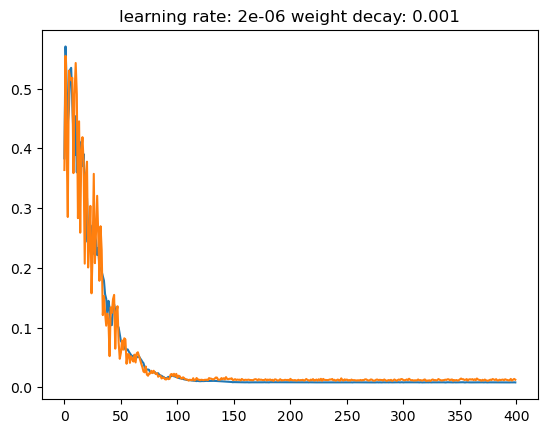

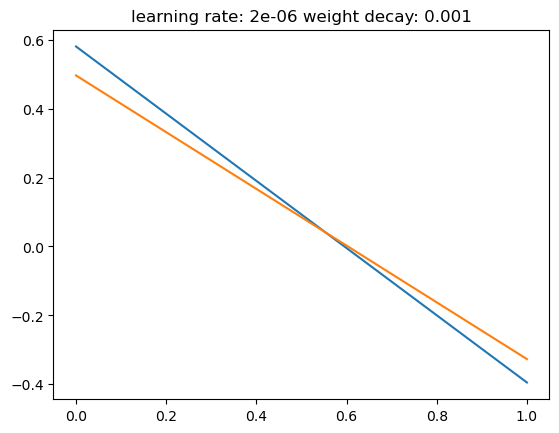

In [113]:
lr = 2e-6
wd = 1e-3
model = Network()

epochs = 400
optimizer = torch.optim.Adam(
        model.parameters(),
        lr           = lr,
        weight_decay = wd
    )

gamma = 0.96#0.85
# scheduler_step_size = 1
# scheduler = lr_scheduler.StepLR(
#     optimizer,
#     step_size = scheduler_step_size, 
#     gamma     = gamma)

scheduler = lr_scheduler.ExponentialLR(
    optimizer, 
    #step_size = scheduler_step_size, 
    gamma     = gamma)

train_losses = []
val_losses   = []
lrs          = []
for epoch in range(epochs):
    train_loss = train_one_epoch(model,optimizer)
    val_loss   = validate_one_epoch(model,optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    lrs.append(scheduler.optimizer.param_groups[0]['lr'])
    scheduler.step()
    print("EPOCH: ",epoch + 1, " Train loss: ", round(train_loss,4), " Val loss: ",round(val_loss,4), " LR: ",round(scheduler.optimizer.param_groups[0]['lr'],10))

txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
plt.title(txt)
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

for batch in validation_generator:
    break
output = model(batch[0])
output
plt.title(txt)
plt.plot(output.detach().numpy()*3.1415926)
plt.plot(batch[1].detach().numpy()*3.1415926)
plt.show()

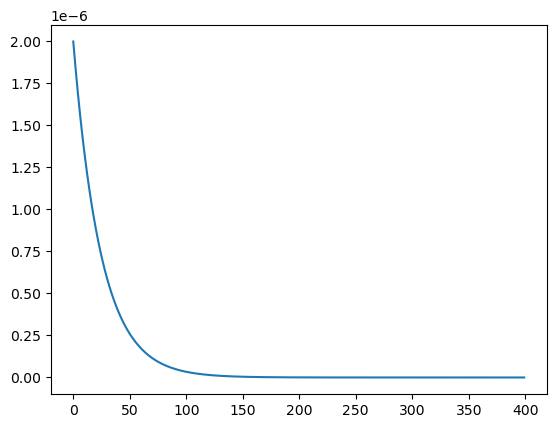

In [114]:
plt.plot(lrs)

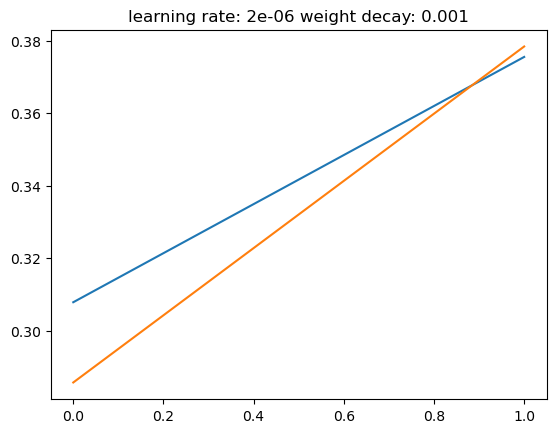

In [116]:
for batch in validation_generator:
    break
output = model(batch[0])
output
plt.title(txt)
plt.plot(output.detach().numpy()[:50])#*3.1415926)
plt.plot(batch[1].detach().numpy()[:50])#*3.1415926)
plt.show()

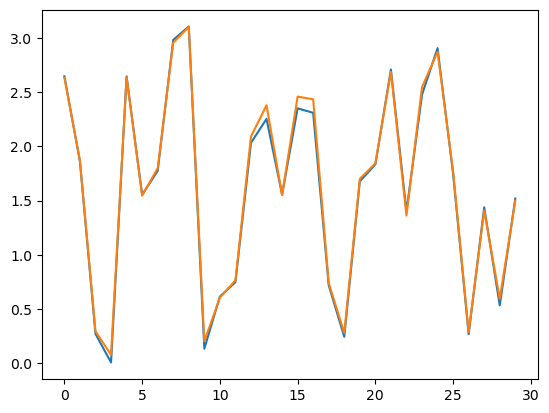

In [118]:
plt.plot(real)
plt.plot(outputs)

2.09615175565884


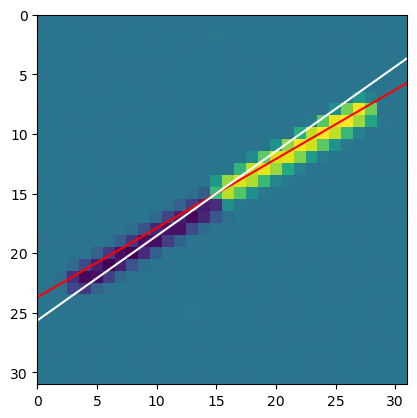

1.3434253593431518


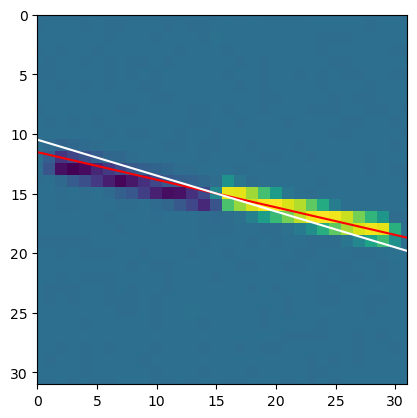

2.020207239959036


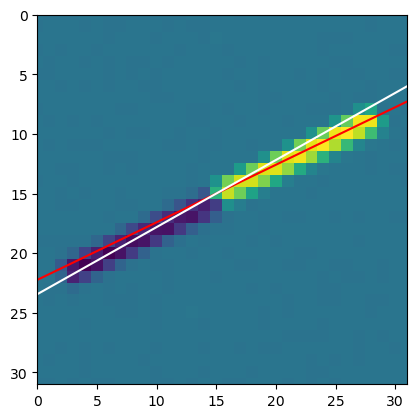

0.09193867814061174


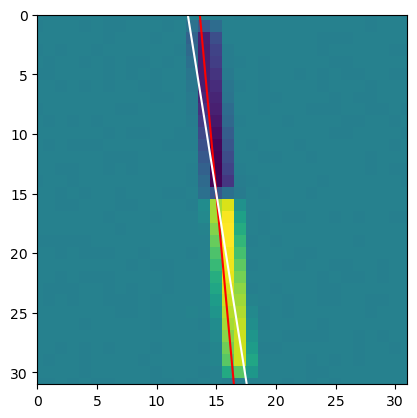

0.15448261151277232


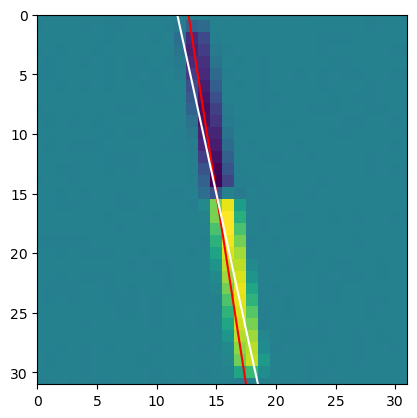

0.7947066502808952


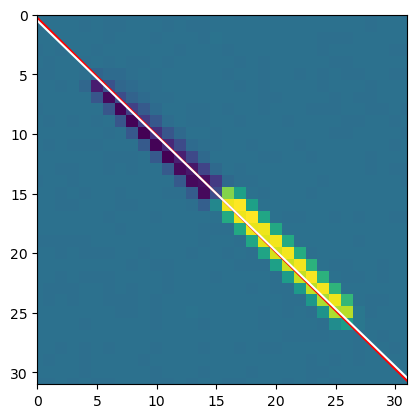

2.0085469966821914


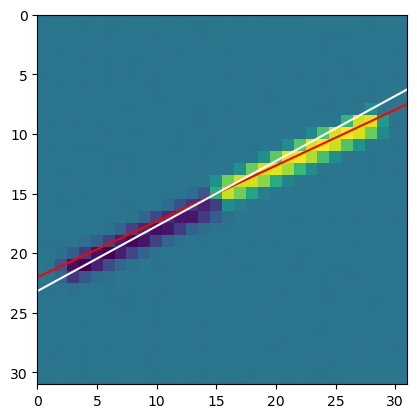

2.4741864282420347


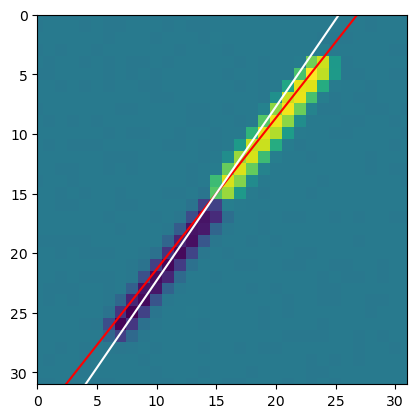

2.6110321858184053


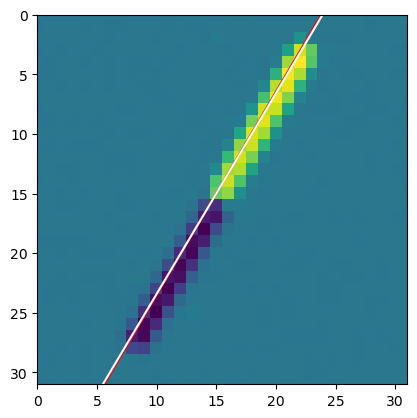

2.902371607131806


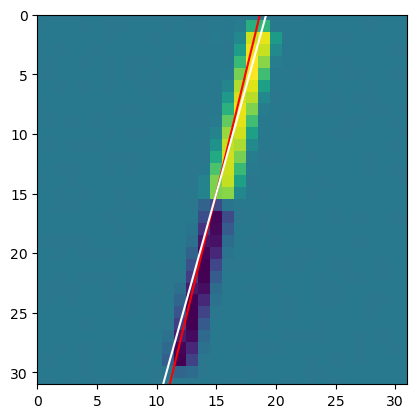

1.8404912969162053


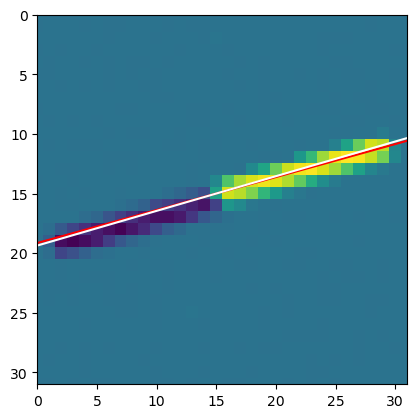

2.0749176040014023


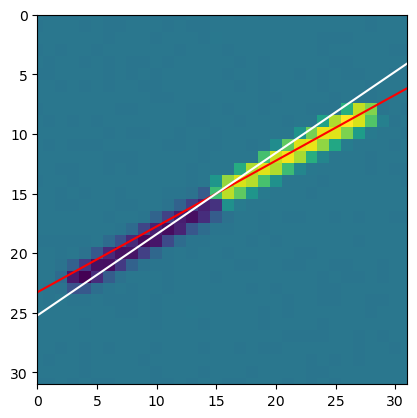

1.795684916694829


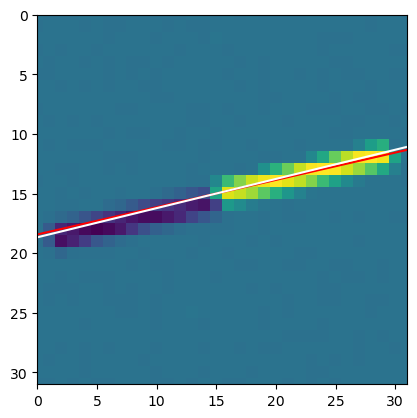

1.4994203921789786


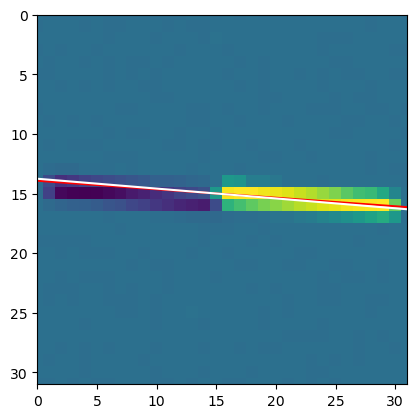

1.861249641690242


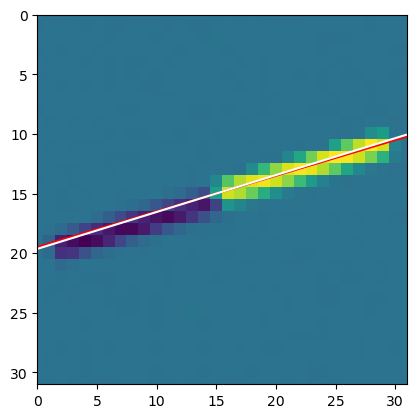

2.927482496858876


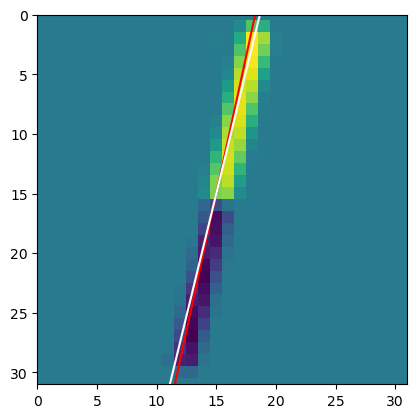

1.1285140878174202


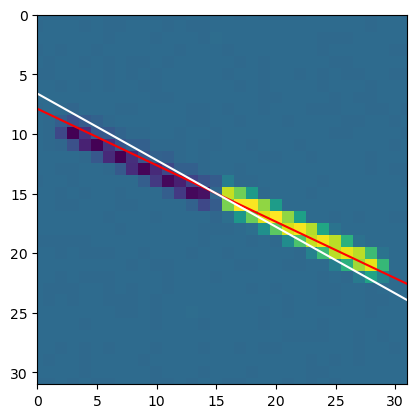

0.23240397225642528


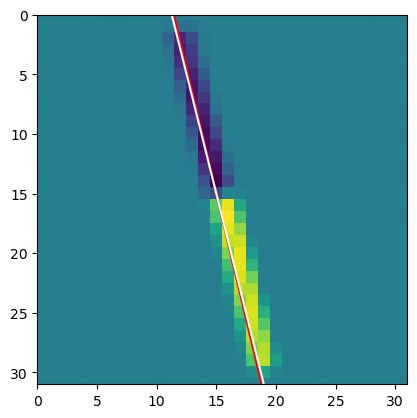

0.23151222483700562


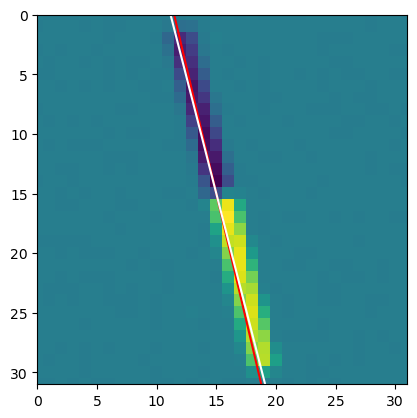

1.6616508662507863


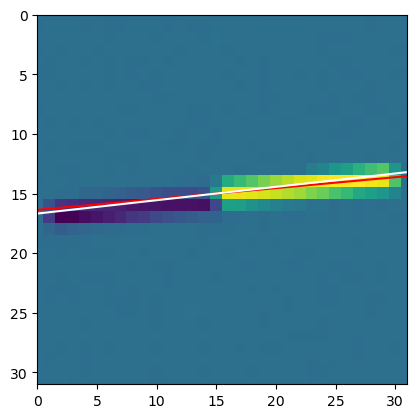

2.568240159284393


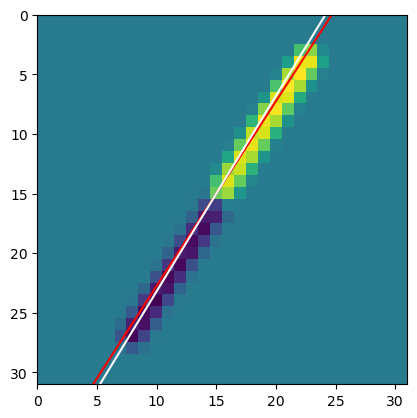

1.9901442831895875


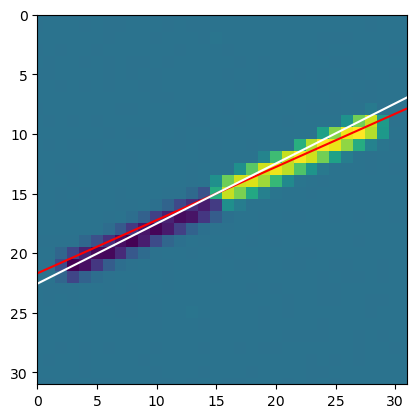

0.5484376605034224


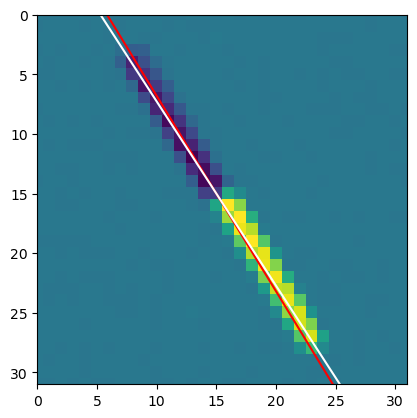

1.0052773746474042


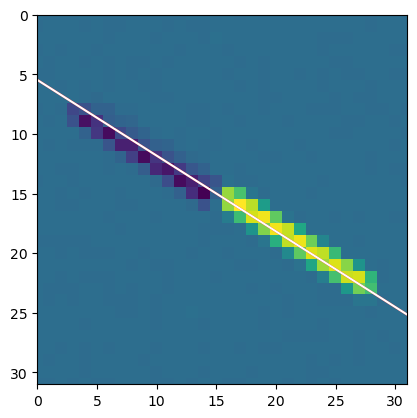

2.199521007786976


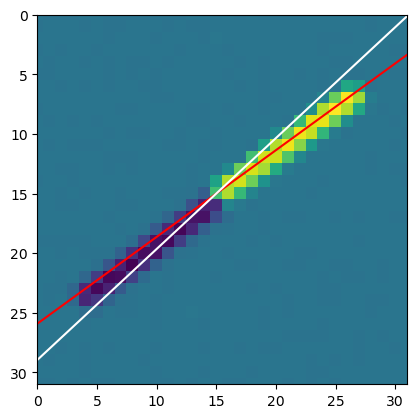

2.167167833374094


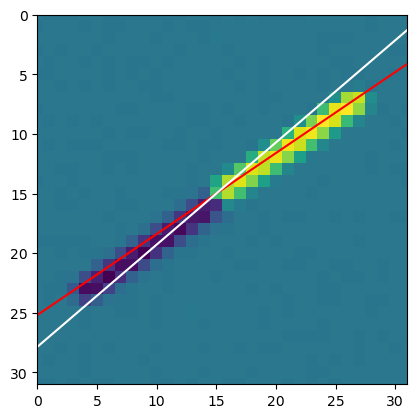

0.1248923621429055


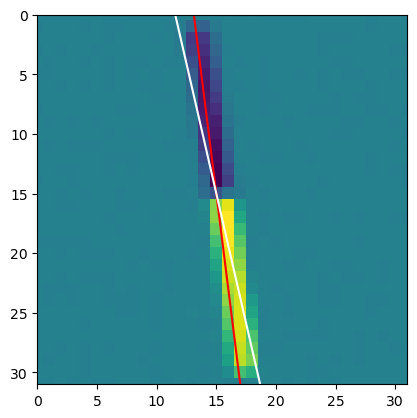

0.20824255921159981


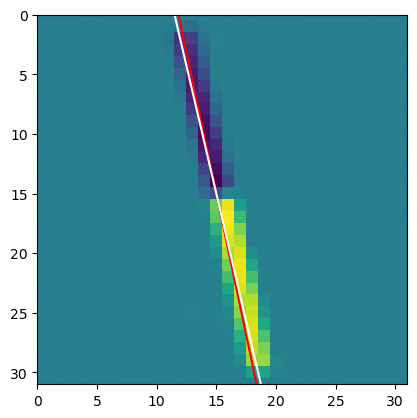

1.395718023017372


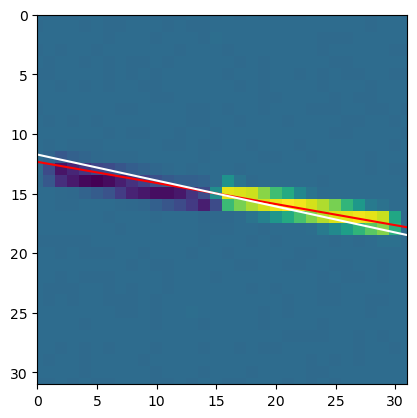

0.9393621898593888


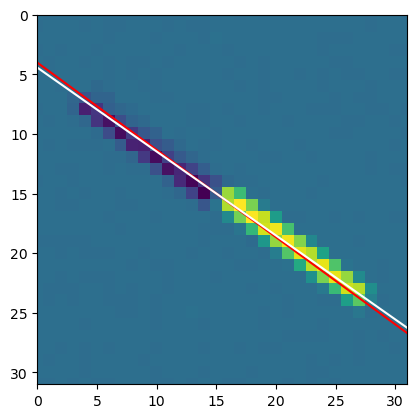

In [119]:
test_IDs = [ random.randint(0,999) for i in range(100) ]

real = []
outputs = []
for ID in test_IDs[:30]:
    input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/images/"
    label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/labels/"
    
    X = torchvision.io.read_image(
                input_dir + str(ID) + ".png "
            ).to(torch.float32)
    plt.imshow(X[1])
    X = X/256.
    
    with open(label_dir + str(ID), 'rb') as fb:
        Y  = pickle.load(fb)
        Y = Y[1][0]#/3.1415926
        
    #Y = Y + 0.5
        
    output = (float(model(X[1].unsqueeze(0).unsqueeze(0))) + 0.5 )*3.1415926
    print(Y)
    
    real.append(Y)
    outputs.append(output)
    
    #plt.plot( [16 - 50*math.tan(Y),16 ,16 + 50*math.tan(Y)],[16 - 50, 16,16 + 50], c='r')
    plt.plot( [15 - 50*math.tan(Y),15 ,15 + 50*math.tan(Y)],[15 - 50, 15,15 + 50], c='r')
    plt.plot( [15 - 50*math.tan(output),15 ,15 + 50*math.tan(output)],[15 - 50, 15,15 + 50], c='w')
    
    plt.xlim(0,31)
    plt.ylim(31,0)
    
    #plt.axvline( x = (Y + 1)*16, c='w' )
    #plt.axvline( x = (output + 1.)*16, c='r')
    plt.show()
    
        

In [183]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        list_IDs,
    ):
        self.list_IDs  = list_IDs
        self.cache     = {}
        self.input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/images/"
        self.label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/labels/"
        
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        if ID in self.cache:
            X = self.cache[ID]['X']
            Y = self.cache[ID]['Y']
        else:
            X = torchvision.io.read_image(
                self.input_dir + str(ID) + ".png "
            ).to(torch.float32)
            X = X[1].unsqueeze(0)/256.
            
            with open(self.label_dir + str(ID), 'rb') as fb:
                Y  = pickle.load(fb)
                
            #Y = [ (i + 3.)/6. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            #Y = [ i/3. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            
            Y = Y[1][0]/3.1415926
            Y = Y - 0.5
            
            Y = torch.tensor( Y, dtype=torch.float32 ).unsqueeze(0)
            
            if psutil.virtual_memory().percent < 50:
                data = {
                    'X' : X,
                    'Y' : Y
                }
                self.cache[ID] = data
        return X,Y
    
all_ids = [str(i) for i in  list(np.arange(0,10000,1))]
train_ids = all_ids[:8000]
val_ids   = all_ids[8000:]#1000]

# train_ids = all_ids[:32]
# val_ids   = all_ids[32:64]#1000]

params = {
    'batch_size'  : 32,
    'shuffle'     : True,
    #'num_workers' : 2
}
training_set         = Dataset(train_ids)
training_generator   = torch.utils.data.DataLoader(
                            training_set,
                            **params,
                            pin_memory=True
                        )
validation_set       = Dataset(val_ids)
validation_generator = torch.utils.data.DataLoader(
                            validation_set,
                            **params,
                            pin_memory=True
                        )

In [184]:
model = Network()
no_of_params(model)
#model(torch.randn(32,1,32,32))

74405

In [369]:
lr = 1e-8
wd = 1e-3
model = Network()

epochs = 100
optimizer = torch.optim.Adam(
        model.parameters(),
        lr           = lr,
        weight_decay = wd,
    )



#gamma = 0.8#0.85
#scheduler_step_size = 1
# scheduler = lr_scheduler.StepLR(
#     optimizer,
#     step_size = scheduler_step_size, 
#     gamma     = gamma)

# scheduler = lr_scheduler.ExponentialLR(
#     optimizer, 
#     #step_size = scheduler_step_size, 
#     gamma     = gamma,
# )

# scheduler = lr_scheduler.CosineAnnealingLR(
#     optimizer, 
#     T_max= 100,
#     eta_min= 1e-10,
#     #step_size = scheduler_step_size, 
#     #gamma     = gamma,
# )

# NOT WORKING AS EXPECTED
# scheduler = lr_scheduler.OneCycleLR(
#     optimizer,
#     max_lr=1e-6,
#     steps_per_epoch=len(training_generator),
#     epochs=5
# )

def scale(x):
    return x

scheduler = lr_scheduler.CyclicLR(
    optimizer,
    base_lr=1e-8,
    max_lr=1e-6,
    cycle_momentum=False,
    gamma=1,
    step_size_up=10,
    step_size_down =10,
    mode='triangular2',
    #scale_fn=lambda x: x*0.8
#     steps_per_epoch=len(training_generator),
#     epochs=5
)

train_losses = []
val_losses   = []
lrs          = []
for epoch in range(epochs):
    #train_loss = train_one_epoch(model,optimizer)
    #val_loss   = validate_one_epoch(model,optimizer)
    #train_losses.append(train_loss)
    #val_losses.append(val_loss)
    optimizer.step()
    lrs.append(scheduler.optimizer.param_groups[0]['lr'])
    scheduler.step()
    #print("EPOCH: ",epoch + 1, " Train loss: ", round(train_loss,4), " Val loss: ",round(val_loss,4), " LR: ",round(scheduler.optimizer.param_groups[0]['lr'],10))

# txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
# plt.title(txt)
# plt.plot(train_losses)
# plt.plot(val_losses)
# plt.show()

# for batch in validation_generator:
#     break
# output = model(batch[0])
# output
# plt.title(txt)
# plt.plot(output.detach().numpy()*3.1415926)
# plt.plot(batch[1].detach().numpy()*3.1415926)
# plt.show()

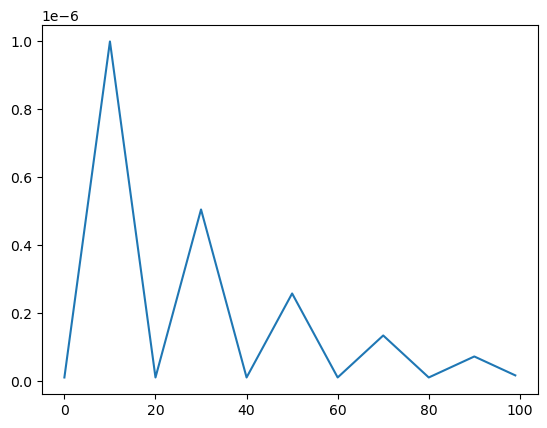

In [370]:
plt.plot(lrs)

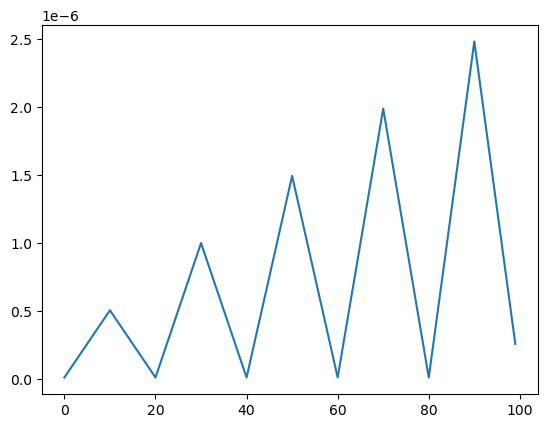

In [266]:
plt.plot(lrs)